# DEEP LEARNING
## Assignment 2 - Time series forecasting
In this assigment we are given a 1000 points univariate time series
where our objective is to predict the values of the following 200 points.

In [24]:
from typing import Tuple

import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import History
from keras.engine.saving import load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Optimizer, Adam
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:

time_series: np.ndarray = loadmat('data/Xtrain.mat')['Xtrain']
time_series: np.ndarray = np.loadtxt('data/Xtrain.csv', delimiter=',')
time_series = np.reshape(time_series, newshape=(time_series.shape[0], 1))
data_points = time_series.shape[0]
print(data_points)

10093


Plotting of the time series

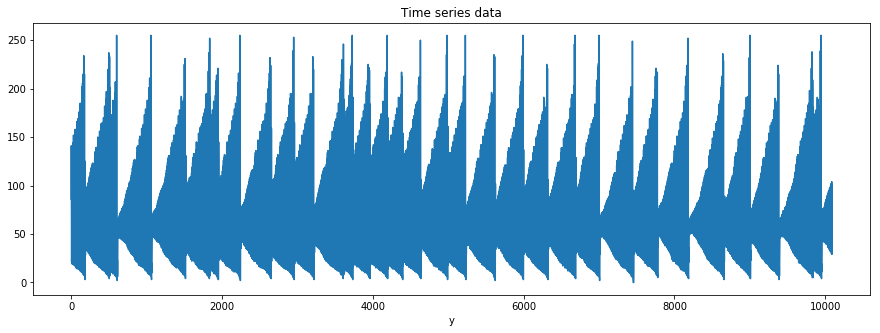

In [4]:
plt.figure(1, figsize=[15, 5])
plt.plot(time_series)
plt.xlabel('x')
plt.xlabel('y')
plt.title('Time series data')
plt.show()

First we are going to analyze the time series, to see
if we can extract valuable information about the time series that
help us regarding to the configuration of the network. For example, 
we can check the autocorrelation and the partial autocorrelation:

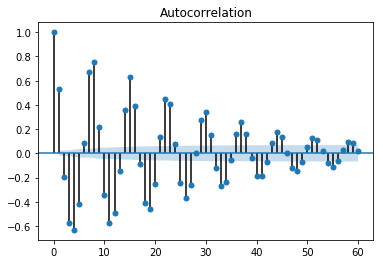

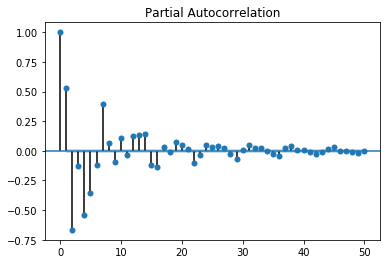

In [5]:
plot_acf(time_series, lags=60)
plt.show()
plot_pacf(time_series, lags=50)
plt.show()

We can observe in both plots, the autocorrelation and partial 
autocorrelation, that there is an influence in the value of a point
and the previous points. This influence lasts for at least 40 points,
when the influence falls under the confidence interval. 

This could give us a hint about the time windows.

### Preprocessing
In order to work with the dataset, we are going to __normalize__ it,
scaling it between [-1,1]. The _MinMaxScaler_ object will be used
later to denormalize also.

In [6]:
min_max_scaler = preprocessing.MinMaxScaler()
time_series = min_max_scaler.fit_transform(time_series)

In order to face this problem, we are going to use a rolling windows
that will go along the time series. At each step, constant size 
features (inputs) and outputs are extracted, and therefore each series
can be a source of many input/output records.

One of the best loss measures for this kind of data is the Root
Mean Squared Error (RMSE) that we will implement in order to use it
in the Keras framework.

In [7]:
from keras import backend, Input, regularizers, Model

def root_mean_square_error(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

At first, we are going to use the following structure:

- __Input__: [x(1), x(2), ..., x(time_windows)]
- __Output__: [x(time_windows + 1)]

In this way, we will predict the following step of a given input,
that will be used for the following prediction.

To process the data, we will use the following function:

In [8]:
def process_data(data: np.ndarray, x_window_size: int, y_window_size: int = 1,
                 dimensions: int = 2) -> Tuple[np.ndarray, np.ndarray]:
    """
    Method that process a time series and creates the data required to train and test the
    neural network.

    For example, for a x windows of size 3 and y, 1:

    [1, 2, 3, 4, 5] ->  [[1, 2, 3], [2, 3, 4]]; [[4], [5]]

    :param data: time series data
    :param x_window_size: number of data points that are included in the x elements
    :param y_window_size: number of data points that are included in the y elements
    :param dimensions: dimensionality of the data, 2D or 3D depending of the network
    :return: tuple with the values of x and y and the specified shapes
    """
    n_possible_elements = data.shape[0] - x_window_size - y_window_size
    if dimensions == 2:
        shape_x = (x_window_size,)
        shape_y = (y_window_size,)
    else:
        shape_x = (x_window_size, 1)
        shape_y = (y_window_size, 1)
    x = np.empty((n_possible_elements,) + shape_x)
    y = np.empty((n_possible_elements,) + shape_y)
    for i in range(n_possible_elements):
        x_end = i + x_window_size
        y_end = x_end + y_window_size
        x_element = np.reshape(data[i:x_end], newshape=shape_x)
        y_element = np.reshape(data[x_end:y_end], newshape=shape_y)
        x[i] = x_element
        y[i] = y_element
    return x, y

We will use different windows size during the assigment to compare
the effect they makes in the predictions. The dimensions argument
will be used depending on the requirements the architecture as there
will be some that use a 2D arrays, with the [examples, data], and others
will use 3D arrays, with [examples, steps, features].

As we are planning to forecast 200 steps, we are going to divide the
data in the training set and the validation set, with 800 and 200
data points respectively

### First architecture MLP
The first architecture we are going to use is a multilayer
neural network. The definition is the following:

In [9]:
class MLP:
    def __init__(self, input_size: Tuple, optimizer: Optimizer, loss, hidden_layers: Tuple[int] = (3, 3),
                 activation: str = 'relu', output_activation: str = 'relu',
                 dropout: float = 0., batch_normalization: bool = False,
                 weight_decay_l1: float = 0., weight_decay_l2: float = 0.):
        # define model
        self.hidden_layers = hidden_layers
        # create the model
        inputs = x_value = Input(shape=input_size)
        # rest of the hidden layers if any
        for neurons in hidden_layers:
            x_value = Dense(neurons, activation=activation,
                      kernel_regularizer=regularizers.l1_l2(l1=weight_decay_l1, l2=weight_decay_l2),
                      bias_regularizer=regularizers.l1_l2(l1=weight_decay_l1, l2=weight_decay_l2))(x_value)
            if dropout > 0.:
                x_value = Dropout(dropout)(x_value)
            if batch_normalization:
                x_value = BatchNormalization()(x_value)
        predictions = Dense(1, activation=output_activation)(x_value)
        self.model = Model(inputs=inputs, outputs=predictions)
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, inputs: np.ndarray, outputs: np.ndarray, batch_size: int = 1, epochs: int = 100) -> History:
        return self.model.fit(inputs, outputs, batch_size=batch_size, epochs=epochs)

    def predict(self, data, number_of_steps):
        predictions = np.empty(shape=(number_of_steps,))
        data_shape = data.shape

        for i in range(predictions.shape[0]):
            predicted_value = self.model.predict(data)
            predictions[i] = predicted_value.item()
            # remove first element and add the prediction
            data = np.reshape(np.append(data[0][1:], predicted_value.item()), newshape=data_shape)
        return predictions

    def save_model(self, name):
        self.model.save('saved-models/' + name)

    def load_model(self, name):
        self.model = load_model(name)

We can see an example of this architecture with a windows of 20
steps, 2 hidden layers with three neurons using ReLu and Adam as optimizer:

In [14]:
windows = 30
x, y = process_data(time_series, x_window_size=windows, y_window_size=1, dimensions=2)

x_test = x[800:1000]
y_test = y[800:1000]
x = x[:800]
y = y[:800]

keras.backend.clear_session()
optimizer = Adam(0.01)
loss = root_mean_square_error
model = MLP(input_size=(windows,), optimizer=optimizer, loss=loss)

history = model.fit(x, y, batch_size=1, epochs=10)
val_error = model.model.evaluate(x_test, y_test)
print('The validation error using x_test and y_test is {0}'.format(val_error))

Epoch 1/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0899
Epoch 2/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0684
Epoch 3/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0612
Epoch 4/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0610
Epoch 5/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0547
Epoch 6/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0520
Epoch 7/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0542
Epoch 8/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0490
Epoch 9/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0527
Epoch 10/10
200/200 [==============================] - 0s 414us/step
The validation error using x_test and y_test is 0.026464387029409408


The validation error is low, meaning that this network is already
able to predict with good accuracy the next step of a given windows.

However, when we try to predict 200 steps using the previous predictions: 

In [28]:
test = np.reshape(x_test[0], newshape=(1, windows))
predictions = model.predict(test, 200)

predictions = np.reshape(predictions, newshape=y_test.shape)
predictions = min_max_scaler.inverse_transform(predictions)
truth = min_max_scaler.inverse_transform(y_test)

rmse_prediction = np.sqrt(mean_squared_error(predictions, truth))
print('The error predicting 200 steps is {0}'.format(rmse_prediction))

The error predicting 200 steps is 86.28268638624922


We can see this error is very high. We can plot to see the results
better. To do that we will define the following function:

In [29]:
def plot_comparison(predicted_data: np.ndarray, real_data: np.ndarray, 
                    title: str = 'Comparison predicted and real values'):
    """
    Method to plot the predicted and the real values of the time series

    :param predicted_data: predicted data by the neural network
    :param real_data: real data that should has been predicted
    :param plot: flag to show the plot
    :param title: title of the plot
    """
    plt.figure(1, figsize=[15, 5])
    plt.plot(predicted_data, label='Predicted data')
    plt.plot(real_data, label='Real data')
    plt.xlabel('x')
    plt.xlabel('y')
    plt.title(title)
    plt.legend()
    plt.show()

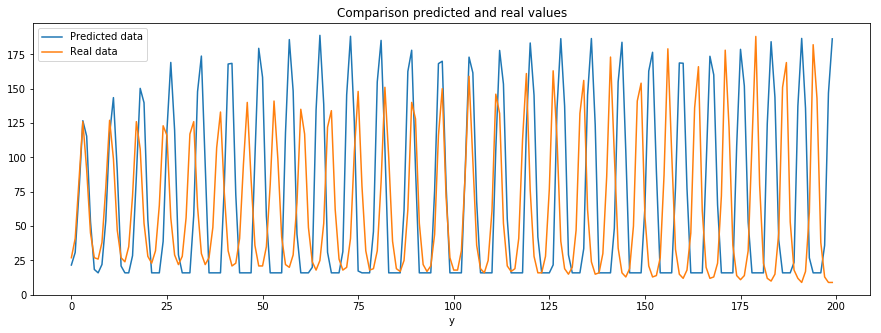

In [31]:
plot_comparison(predictions, truth)

We are going to use different configurations to see what yields the
better results.

In [ ]:
# predictions = list()
# windows_size = [5, 10, 20, 30, 40, 50]
# 
# for windows in windows_size:
#     for layers in range(1, 3):
#         
# x, y = process_data(time_series, window_size=windows, dimensions=2)
# 
# x_test = x[800:1000]
# y_test = y[800:1000]
# x = x[:800]
# y = y[:800]



